<a href="https://colab.research.google.com/github/srijansingh53/Metal-dent-detection/blob/master/NEU_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import pandas as pd

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, sampler

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.chdir('/content/drive/My Drive/metal dent detection/')
!ls

codes  dataset	model.pth


In [0]:
''' Declaring important parameters '''

data_dir = 'dataset/NEU/NEU-CLS-64'
nThreads = 4
batch_size = 32

In [34]:
''' Loading dataset and splitting it into train and test set '''
def load_split_train_test(datadir, valid_size = .2):

    train_transforms = transforms.Compose([transforms.Resize(224),
                                           transforms.ToTensor(),
                                           ])
    test_transforms = transforms.Compose([transforms.Resize(224),
                                          transforms.ToTensor(),
                                          ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = sampler.SubsetRandomSampler(train_idx)
    test_sampler = sampler.SubsetRandomSampler(test_idx)
    trainloader = DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['cr', 'gg', 'in', 'pa', 'ps', 'rp', 'rs', 'sc', 'sp']


<class 'torch.Tensor'>
torch.Size([64, 3, 224, 224])
torch.Size([64])


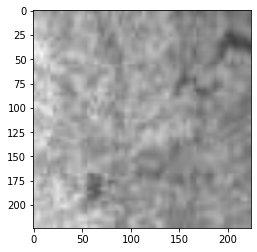

In [35]:
''' Vizualize Images from dataloader '''

dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [0]:
n_classes = 9
model.fc = nn.Sequential(
                      nn.Linear(2048, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

In [39]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=9, bias=True)
  (4): LogSoftmax()
)

In [40]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

24,034,889 total parameters.
526,857 training parameters.


In [41]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'saved_models/model.pth')

Epoch 1/10.. Train loss: 2.127.. Test loss: 1.881.. Test accuracy: 0.331
Epoch 1/10.. Train loss: 0.937.. Test loss: 2.127.. Test accuracy: 0.146
Epoch 1/10.. Train loss: 0.645.. Test loss: 2.340.. Test accuracy: 0.286
Epoch 1/10.. Train loss: 0.618.. Test loss: 1.323.. Test accuracy: 0.568
Epoch 1/10.. Train loss: 0.526.. Test loss: 1.209.. Test accuracy: 0.596
Epoch 1/10.. Train loss: 0.457.. Test loss: 1.320.. Test accuracy: 0.543
Epoch 1/10.. Train loss: 0.459.. Test loss: 0.828.. Test accuracy: 0.662
Epoch 1/10.. Train loss: 0.411.. Test loss: 0.404.. Test accuracy: 0.862
Epoch 1/10.. Train loss: 0.374.. Test loss: 0.384.. Test accuracy: 0.860
Epoch 2/10.. Train loss: 0.420.. Test loss: 0.284.. Test accuracy: 0.896
Epoch 2/10.. Train loss: 0.372.. Test loss: 0.268.. Test accuracy: 0.907
Epoch 2/10.. Train loss: 0.433.. Test loss: 0.250.. Test accuracy: 0.908
Epoch 2/10.. Train loss: 0.365.. Test loss: 0.260.. Test accuracy: 0.911
Epoch 2/10.. Train loss: 0.327.. Test loss: 0.247..

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist

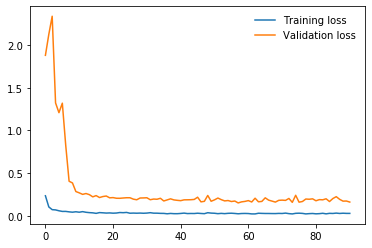

In [43]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()